In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import sys
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention

sys.path.append('..')
from src.data.make_dataset import make_dataset

In [2]:
DATA_PATH = '../data/processed/EEA-SK-Ba-trend.csv'
N_PAST = 48
N_FUTURE = 1

In [3]:
df = pd.read_csv(DATA_PATH)
# take only data until 2019 based on DatetimeBegin column
df['DatetimeBegin'] = pd.to_datetime(df['DatetimeBegin'])
df = df[df['DatetimeBegin'] < '2020-01-01']
df = df[['PM10 Concentration', 'PM2.5 Concentration', 'NO2 Concentration']]

In [4]:
train_X, train_Y, val_X, val_Y, test_X = make_dataset(data_src=df, n_past=N_PAST, n_future=N_FUTURE)

In [5]:
in_scaler = StandardScaler()
out_scaler = StandardScaler()

train_X = train_X.reshape(-1, train_X.shape[-1])
train_X = in_scaler.fit_transform(train_X)
train_X = train_X.reshape(-1, N_PAST, train_X.shape[-1])

train_Y = train_Y.reshape(-1, train_Y.shape[-1])
train_Y = out_scaler.fit_transform(train_Y)
train_Y = train_Y.reshape(-1, N_FUTURE, train_Y.shape[-1])

val_X = val_X.reshape(-1, val_X.shape[-1])
val_X = in_scaler.transform(val_X)
val_X = val_X.reshape(-1, N_PAST, val_X.shape[-1])

val_Y = val_Y.reshape(-1, val_Y.shape[-1])
val_Y = out_scaler.transform(val_Y)
val_Y = val_Y.reshape(-1, N_FUTURE, val_Y.shape[-1])

real_values = test_X.copy()[:, -1, :]
test_X = test_X.reshape(-1, test_X.shape[-1])
test_X = in_scaler.transform(test_X)
test_X = test_X.reshape(-1, N_PAST, test_X.shape[-1])

In [6]:
print(f'Train set shape: {train_X.shape}         Train labels shape: {train_Y.shape}')
print(f'Validation set shape: {val_X.shape}     Validation labels shape: {val_Y.shape}')
print(f'Test set shape: {test_X.shape}')

Train set shape: (12214, 48, 3)         Train labels shape: (12214, 1, 3)
Validation set shape: (2580, 48, 3)     Validation labels shape: (2580, 1, 3)
Test set shape: (2580, 48, 3)


### Modelling

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

In [8]:
def transformerEncoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def buildModel(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformerEncoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(units=3)(x)
    return tf.keras.Model(inputs, outputs)

In [9]:
transformer = buildModel(
    train_X.shape[1:],
    head_size=128,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.3,
    dropout=0.2
)
transformer.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
transformer.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 3)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 48, 3)                6         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 48, 3)                7683      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                             

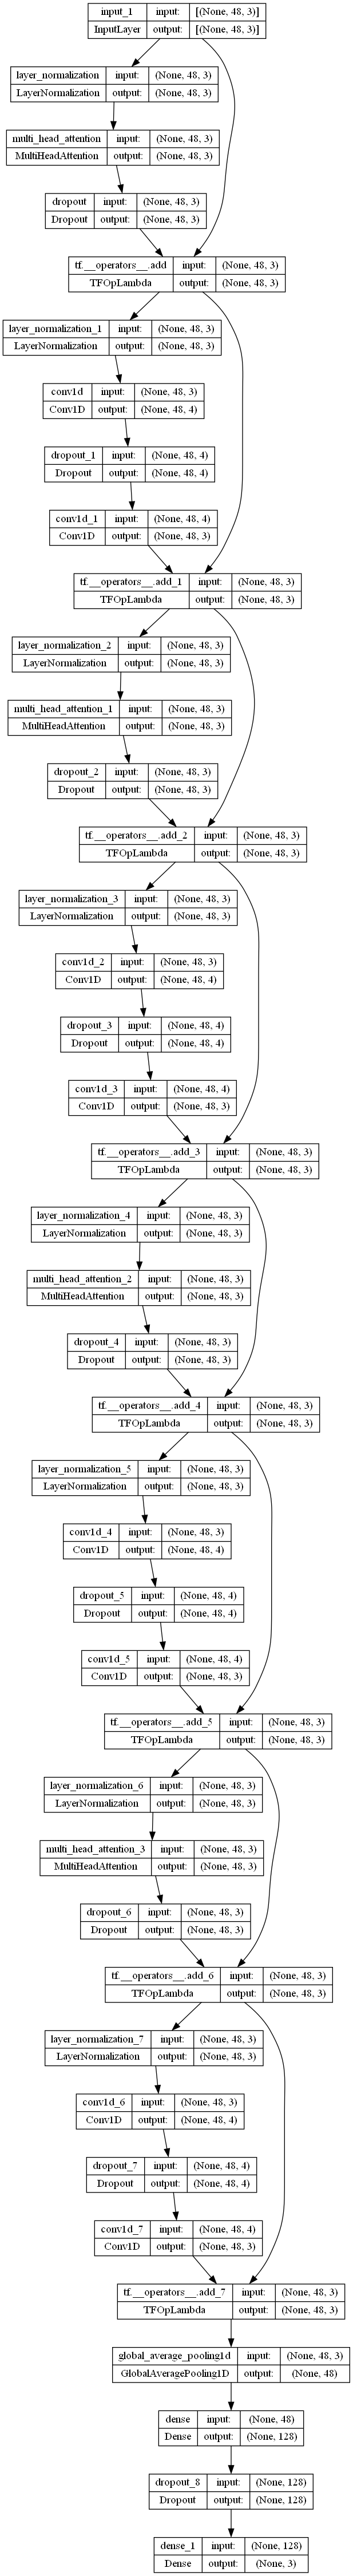

In [10]:
tf.keras.utils.plot_model(transformer, to_file='transformer.png', show_shapes=True)

### Model training

In [11]:
def makeSubplots(modelName, trainHistory, predictions):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(trainHistory.history['loss'], label='train loss')
    axes[0, 0].plot(trainHistory.history['val_loss'], label='val loss')
    axes[0, 0].set_title(f'{modelName} training loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(real_values[:, 0], label='Real values (trend)')
    axes[0, 1].plot(predictions[:, 0], label=f'{modelName} predictions')
    axes[0, 1].set_title(f'{modelName} PM10 predictions')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('PM10 concentration')
    axes[0, 1].legend()

    axes[1, 0].plot(real_values[:, 1], label='Real values (trend)')
    axes[1, 0].plot(predictions[:, 1], label=f'{modelName} predictions')
    axes[1, 0].set_title(f'{modelName} PM2.5 predictions')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('PM2.5 concentration')
    axes[1, 0].legend()

    axes[1, 1].plot(real_values[:, 2], label='Real values (trend)')
    axes[1, 1].plot(predictions[:, 2], label=f'{modelName} predictions')
    axes[1, 1].set_title(f'{modelName} NO2 predictions')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('NO2 concentration')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [12]:
transformer_hist = transformer.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50

764/764 [==============================] - 45s 46ms/step - loss: 0.6945 - mean_absolute_error: 0.6426 - root_mean_squared_error: 0.8334 - mean_absolute_percentage_error: 354.9821 - val_loss: 0.2844 - val_mean_absolute_error: 0.4254 - val_root_mean_squared_error: 0.5334 - val_mean_absolute_percentage_error: 158.9574
Epoch 2/50
764/764 [==============================] - 34s 45ms/step - loss: 0.4978 - mean_absolute_error: 0.5493 - root_mean_squared_error: 0.7056 - mean_absolute_percentage_error: 303.2343 - val_loss: 0.2472 - val_mean_absolute_error: 0.3803 - val_root_mean_squared_error: 0.4973 - val_mean_absolute_percentage_error: 173.6664
Epoch 3/50
764/764 [==============================] - 35s 46ms/step - loss: 0.4634 - mean_absolute_error: 0.5256 - root_mean_squared_error: 0.6808 - mean_absolute_percentage_error: 285.6409 - val_loss: 0.2314 - val_mean_absolute_error: 0.3641 - val_root_mean_squared_error: 0.4813 - val_mean_absolute_percentage_error: 244.7711
Epoch 4/50
764/

81/81 [==============================] - 3s 26ms/step


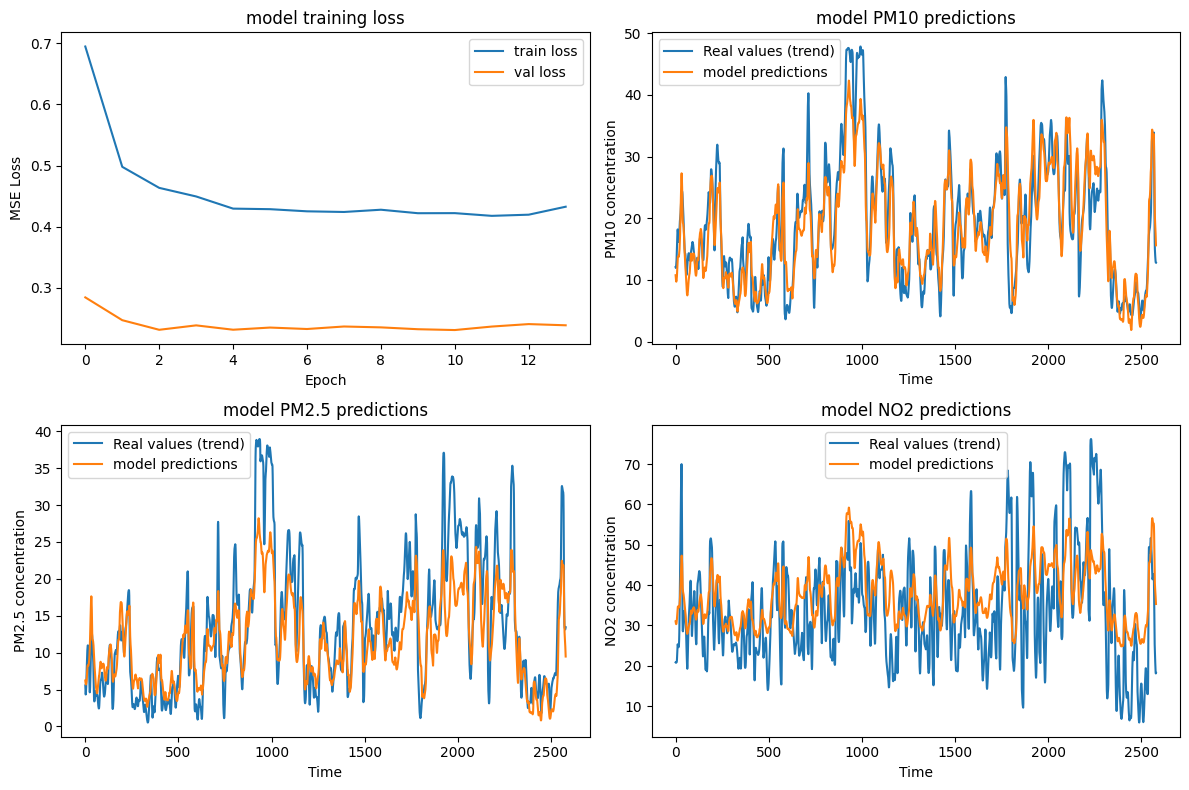

In [13]:
transformer_preds = transformer.predict(test_X)
transformer_preds = out_scaler.inverse_transform(transformer_preds)
makeSubplots(transformer.name, transformer_hist, transformer_preds)

In [14]:
def calculateMetrics(predictions):
    mae = mean_absolute_error(real_values[:, 0], predictions[:, 0])
    mape = mean_absolute_percentage_error(real_values[:, 1], predictions[:, 1])
    rmse = np.sqrt(mean_squared_error(real_values[:, 2], predictions[:, 2]))
    return [mae, mape, rmse]

transformer_metrics = calculateMetrics(transformer_preds)
print(f'Transformer metrics: MAE: {transformer_metrics[0]}, MAPE: {transformer_metrics[1]}, RMSE: {transformer_metrics[2]}')

Transformer metrics: MAE: 3.1344325879793344, MAPE: 0.38603814033293954, RMSE: 11.065236902834751


In [15]:
transformer.save('../models/transformer.keras')